## Shear driven dilatancy

In [1]:
import underworld as uw
import numpy as np
import math
import os
from underworld import function as fn
import glucifer

In [2]:
outputPath = os.path.join(os.path.abspath("."),"Expt1")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

In [3]:
## Physical parameters in the model

bulkVisc = 10.0

In [4]:
minX = 0.0
maxX = 1.0
resX = 48
resY = 48

elementType="Q2/dQ1"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, 0.), 
                                 maxCoord    = ( maxX, 1.),
                                 periodic    = [True, False]  ) 


velocityField           = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField           = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.0

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRateInvFn = fn.tensor.second_invariant(strainRateFn)



In [5]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
top    = mesh.specialSets["MaxJ_VertexSet"]
base   = mesh.specialSets["MinJ_VertexSet"]

# for index in mesh.specialSets["MinJ_VertexSet"]:
#     if mesh.data[index,0] > 0.4 and  mesh.data[index,0] < 0.6:
#         base.remove(index)

BCs = uw.conditions.DirichletCondition( variable        = velocityField, 
                                        indexSetsPerDof = ( iWalls, base) ) 

In [6]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = BCs,
                               fn_viscosity  = 1.0, 
                               fn_bodyforce  = (0.0,  0.0),
                               fn_source    =  -1.0  )


solver = uw.systems.Solver( stokes )

if(uw.nProcs()==1):
    solver.set_inner_method("lu")
    solver.set_penalty(0.0) 
    
solver.options.scr.ksp_rtol = 1.0e-5

# Test to see if these setting are OK

solver.solve( nonLinearIterate=False )
solver.print_stats()



 
Pressure iterations:   8
Velocity iterations:   1 (presolve)      
Velocity iterations:   8 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  10 (total solve)   
 
SCR RHS  solve time: 2.3104e-01
Pressure solve time: 3.2011e-02
Velocity solve time: 2.7330e-03 (backsolve)
Total solve time   : 2.8345e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 




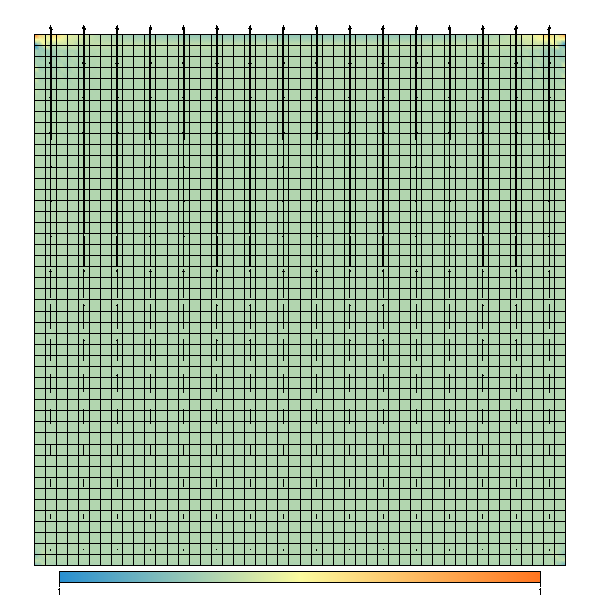

In [7]:
# visualising the result

surfFn = strainRateFn[1]

figMesh = glucifer.Figure(figsize=(600,600))
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=False) )
figMesh.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.1))
figMesh.append( glucifer.objects.SurfaceOnMesh(mesh, surfFn))
figMesh.show()

In [8]:
velocitySourceField = uw.mesh.MeshVariable( mesh=mesh.subMesh,  nodeDofCount=1 )
velocitySourceField.data[:] = 0.

middleNodes = np.where(np.logical_and(np.abs(mesh.subMesh.data[:,0]-0.5) < 0.01,  np.abs(mesh.subMesh.data[:,1]-0.5) < 0.01 ))

velocitySourceField.data[middleNodes] = -10.0

stokes.fn_source = velocitySourceField

solver.solve( nonLinearIterate=False )
solver.print_stats()




 
Pressure iterations:  28
Velocity iterations:   1 (presolve)      
Velocity iterations:  28 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:  30 (total solve)   
 
SCR RHS  solve time: 2.2787e-01
Pressure solve time: 1.0928e-01
Velocity solve time: 2.8210e-03 (backsolve)
Total solve time   : 3.5492e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 




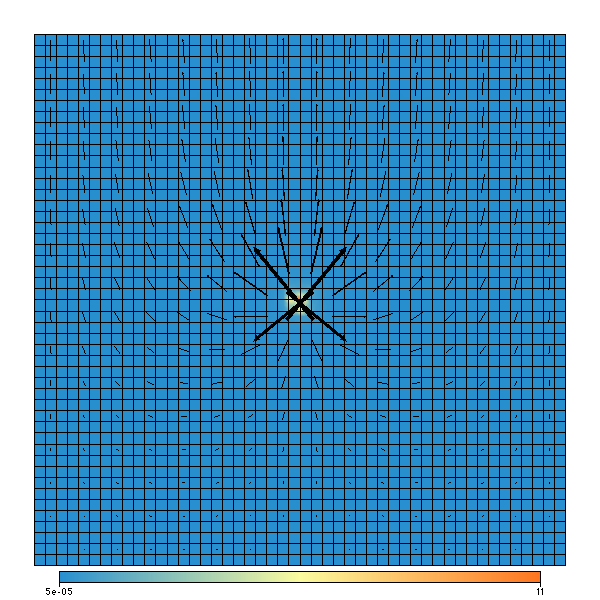

In [10]:
surfFn = strainRateInvFn

figMesh = glucifer.Figure(figsize=(600,600))
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=False) )
figMesh.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=10.0))
figMesh.append( glucifer.objects.SurfaceOnMesh(mesh, surfFn))
figMesh.show()